# Objectives:
### Declumping
- Investigate the distribution of how many non-duplicate-workers are in each cluster
    - Automatically find clumpiness threshold (to keep clusters in which > threshold of unique workers in the cluster have clicked in that cluster multiple times).

# Takeaways:


# Next steps:
### Declumping
- Do any of these clumpy clusters show obvious degrees of clumpiness (lots of workers annotate 2x, 3x, etc)? If so, we’d have the k needed to apply partitioning, e.g. k-means, to that clump.
- Flag areas that need more zoomed-in annotation by detecting regions with a lot of clumpiness


In [1]:
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from BaseAnnotation import BaseAnnotation
from QuantiusAnnotation import QuantiusAnnotation
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
import numpy as np

%matplotlib inline

worker_marker_size = 8
cluster_marker_size = 40
bigger_window_size = True
img_height = 300
show_correctness = True
correctness_threshold = 4
clustering_params = ['AffinityPropagation', -350]

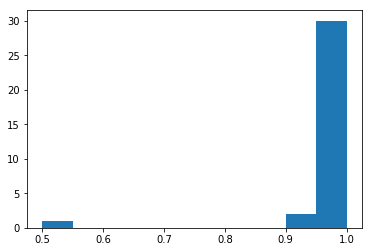

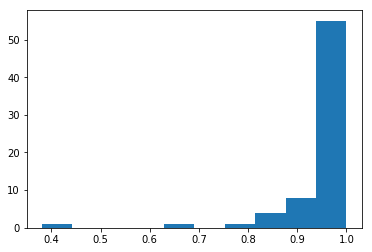

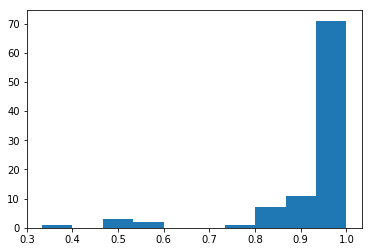

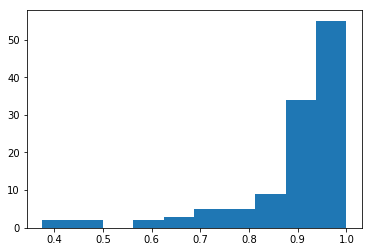

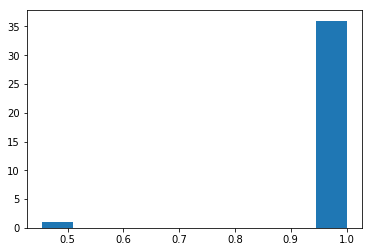

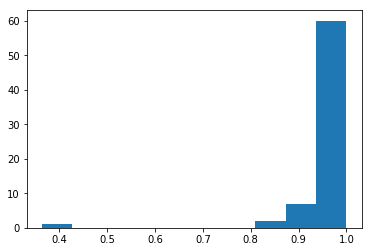

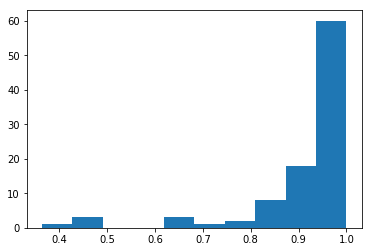

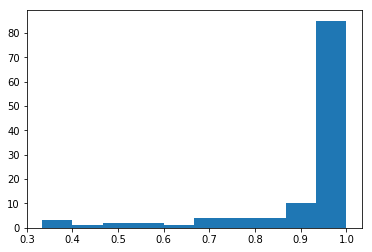

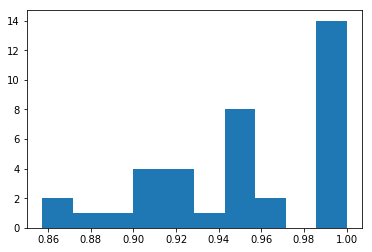

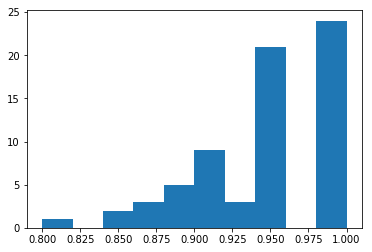

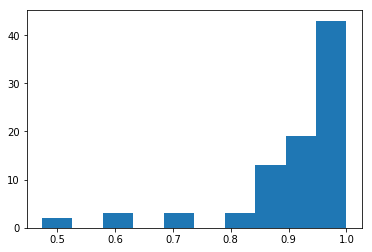

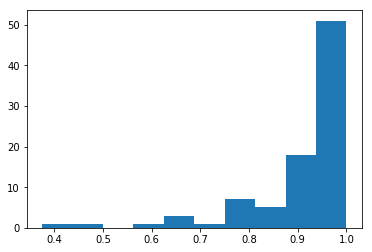

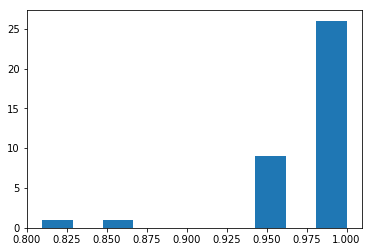

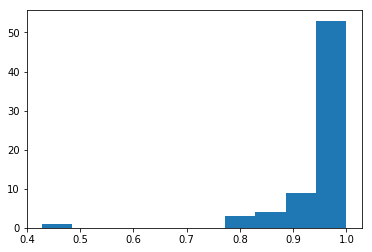

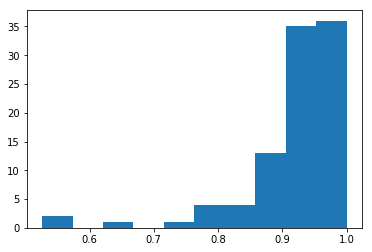

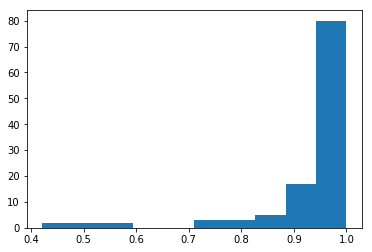

In [2]:
json_filename_list = ['Spots_density_no_tissue.json','Spot_density.json']
density_list = [0.002, 0.004, 0.006, 0.008]
snr_mu_list = [5, 10]
# json_filename_list = ['Spots_density_no_tissue.json']
# density_list = [0.002]
# snr_mu_list = [5]

TPR_list_no_tissue = []
FPR_list_no_tissue = []
TPR_list_with_tissue = []
FPR_list_with_tissue = []
for json_filename in json_filename_list:
    for snr_mu in snr_mu_list:
        for density in density_list:
            img_name = 'snr_' + str(snr_mu)+ '_0_density_' + str(density)
            if (json_filename == 'Spots_density_no_tissue.json'):
                img_filename = img_name+'_spots.png'
                img_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_arrays/'+img_filename
            else:
                img_filename = img_name+'_spot_img.png'
                img_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_images/'+img_filename
            csv_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_data/'+img_name+'_coord_snr_list.csv'
            json_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/'+json_filename

            ba = QuantiusAnnotation(json_filepath)
            sa = SpotAnnotationAnalysis(ba)
            anno_all = ba.df()
            anno_one_image = ba.slice_by_image(anno_all, img_filename)
            ref_kdt = sa.csv_to_kdt(csv_filepath, img_height)
            ref_array = np.asarray(ref_kdt.data)

            # Get large clusters
            clusters = sa.get_clusters(anno_one_image, clustering_params)
            total_num_clusters = len(clusters.index)
            threshold = sa.get_cluster_size_threshold(clusters)
            threshold = math.ceil(threshold)
            small_clusters, large_clusters = sa.sort_clusters_by_size_input_threshold(clusters, threshold)
            
            # For each cluster, calc replication of each worker
            single_fractions = []
            for i in range(len(large_clusters.index)):
                row = large_clusters.iloc[[i]]
                members = row.iloc[0]['members']
                workers = []
                x_coords = []
                y_coords = []
                for member in members:
                    x_coords.append(member[0])
                    y_coords.append(member[1])
                    workers.append(member[3])
                    
                # Calculate replication of unique workers for each cluster
                unique_workers = np.unique(workers)
                num_instances_list = []
                for unique_worker in unique_workers:
                    num_instances_list.append(workers.count(unique_worker))
                singles = num_instances_list.count(1)
                single_fractions.append(singles/len(unique_workers))
            
            # plot single fraction histograms
            fig = plt.figure()
            plt.hist(single_fractions)
            plt.show() 
            